In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats

import pyfstat
from pyfstat.helper_functions import get_sft_as_arrays

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

# Generating  Noise

Example on how to generate Gaussian noise under different conditions 
(non-stationarity, gaps in the data, multiple detectors)
as well as including monochromatic instrumental artifacts, also known as [spectral lines](https://www.gw-openscience.org/O3/o3speclines/).

0. [The SFT format](#the-sft-format)
0. [Using pyfstat.Writer](#pyfstat.writer)
0. [Non-stationary noise](#non-stationarity)
0. [Gaps](#gaps)
0. [Narrow instrumental artifacts](#lines)

## The SFT format <a name="the-sft-format"></a>

Continuous wave signals are quasi-monochromatic long-standing gravitational waves. Standard models, 
such as those corresponding to the signal produced by non-axisymmetric rapidly-spinning neutron stars, 
produce narrow-banded signals which are Doppler-modulated due to the motion of the detector in the Solar system. 
An accessible and open-access review on the topic can be found [here](https://www.mdpi.com/2218-1997/7/12/474).

Due to the well-localization of a signal in a narrow frequency band, 
Forier transforms are suitable tool to analize this sort of data. 
These signals, however, are not completely monochromatic, 
meaning a full-time Fourier transform could risk smearing a signal across a very broad frequency band.
Instead, we work using *Short Fourier Transforms* (SFTs), which are Fourier transforms of short data segments
(typically around 30 minutes). 

This data format is specific of [LALSuite](https://lscsoft.docs.ligo.org/lalsuite/), 
but PyFstat provides functions (`pyfstat.helper_functions.get_sft_as_arrays`) to read them
as Numpy arrays.

## Using pyfstat.Writer<a name="pyfstat.writer"></a>

The most basic example is to generate Gaussian noise as measured by a single detector.
This operation can be performed using `pyfstat.Writer` as follows:

In [2]:
# Setup Writer
writer_kwargs ={"label": "single_detector_gaussian_noise",
                "outdir": "Pyfstat_example_data",
                "tstart": 1238166018,     # Starting time of the observating [GPS time]
                "duration": 5 * 86400,    # Duration [seconds]
                "detectors": "H1",        # Detector to simulate, in this case LIGO Hanford
                "F0": 100.,               # Central frequency band [Hz]
                "Band": 1.,               # Frequency band-width [Hz]
                "sqrtSX": 1e-23,          # Single-sided Amplitude Spectral Density of the noise
                "Tsft": 1800,             # Fourier transform time duration
                "SFTWindowType": "tukey", # Window function to compute short Fourier transforms
                "SFTWindowBeta": 0.01,    # Parameter associated to the window function
               }
writer = pyfstat.Writer(**writer_kwargs)

# Create SFTs
writer.make_data()

14:47 INFO    : Creating Writer object...
14:47 INFO    : Generating SFTs with fmin=99.5, Band=1.0
14:47 INFO    : Got h0=0, not writing an injection .cff file.
14:47 INFO    : Checking if we can re-use existing SFT data file(s)...
14:47 INFO    : ...no SFT file matching 'Pyfstat_example_data/H-240_H1_1800SFT_single_detector_gaussian_noise-1238166018-432000.sft' found. Will create new SFT file(s).
14:47 INFO    : Now executing: lalapps_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="Pyfstat_example_data" --outLabel="single_detector_gaussian_noise" --IFOs="H1" --sqrtSX="1e-23" --SFTWindowType="tukey" --SFTWindowBeta=0.01 --startTime=1238166018 --duration=432000 --fmin=99.5 --Band=1 --Tsft=1800 --ephemEarth="/home/rodrigo/gravity/venv/pyfstat/share/lalpulsar/earth00-40-DE405.dat.gz" --ephemSun="/home/rodrigo/gravity/venv/pyfstat/share/lalpulsar/sun00-40-DE405.dat.gz"
14:47 INFO    : Successfully wrote SFTs to: Pyfstat_example_data/H-240_H1_1800SFT_single_detector_gaussian_noise-12381660

SFT data is saved at the path specified in `writer.sftfilepath `. This binary format can be opened as numpy arrays using `pyfstat.helper.get_sft_as_arrays` as follows:

In [3]:
# Read SFT data into numpy arrays and plot real and imaginary parts
frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

14:47 INFO    : Loading 240 SFTs from H1...
14:47 INFO    : done!
14:47 INFO    : 240 retrieved from H1.


SFT data could contain different detectors which may be operating during different times.
Thus, `timestamps` and `fourier_data` are dictionaries whose keys correspond to detector names (`H1` for LIGO Hanford, `L1` for LIGO Livingston). `timestamps` labels the time at which the data was taken using GPS seconds, while `fourier_data` contains the Fourier amplitude of such data segment. `frequency`, which is common for all the detectors, is a 1D array labeling the frequency bins.

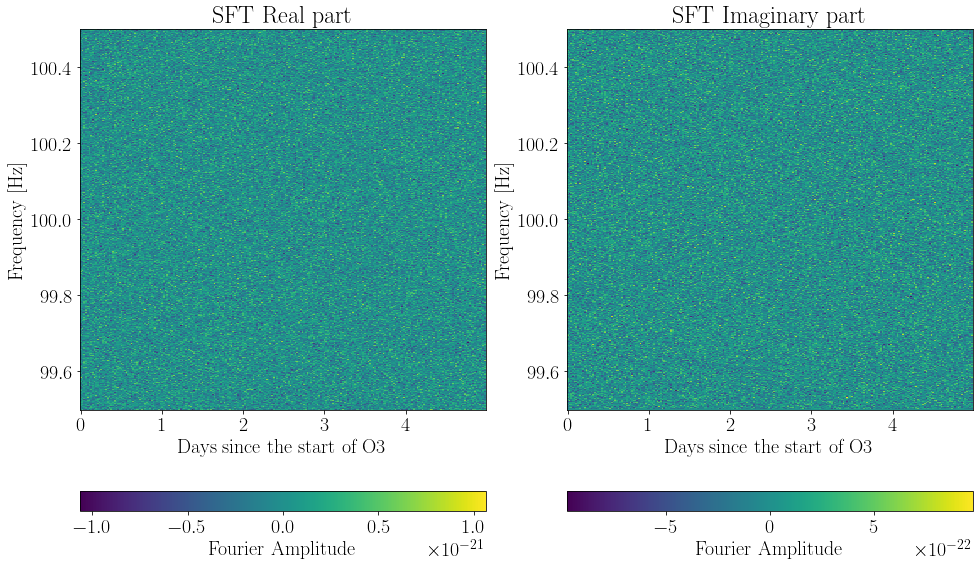

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

for ax in axs:
    ax.set(xlabel="Days since the start of O3", ylabel="Frequency [Hz]")

time_in_days = (timestamps["H1"] - timestamps["H1"][0]) / 86400

axs[0].set_title("SFT Real part")
c = axs[0].pcolormesh(time_in_days, frequency, fourier_data["H1"].real,
                      norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

axs[1].set_title("SFT Imaginary part")
c = axs[1].pcolormesh(time_in_days, frequency, fourier_data["H1"].imag,
                      norm=colors.CenteredNorm())

fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

Since we are generting zero-meanwhite Gaussian noise, 
there is a simple relation between the single-sided amplitude spectral density `sqrtSX` $\sqrt{S_{\text{n}}}$ 
and the variance of the distribution given by
$$
\sigma^2 = \frac{1}{4} T_{\text{SFT}} S_{\text{n}}
$$
where the two $\frac{1}{2}$ factors are due to the use of a *single-sided* ASD 
and the fact that this standard eviation applies to both the real and imaginary parts of the Fourier transform.

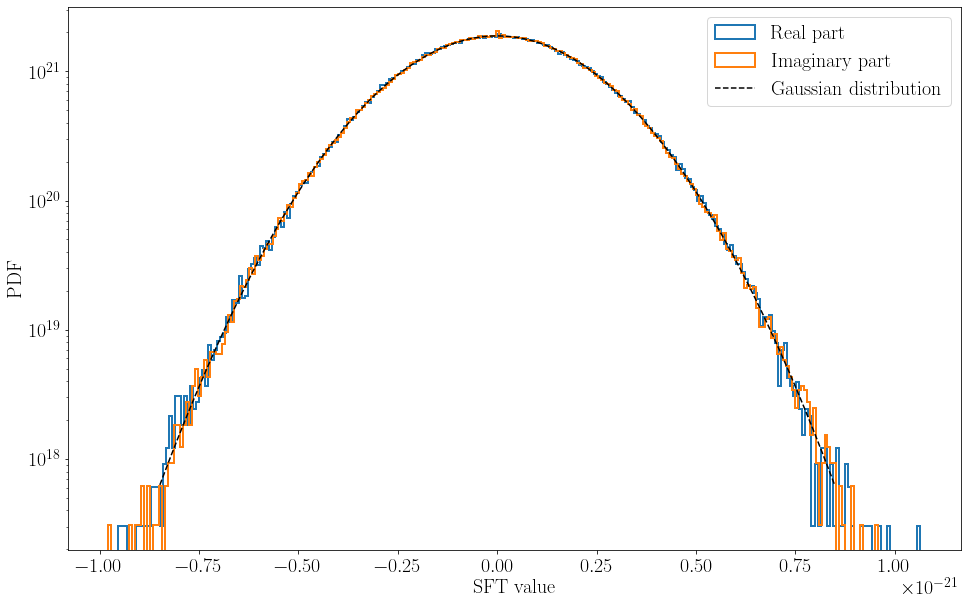

In [5]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set(xlabel="SFT value", ylabel="PDF", yscale="log")

ax.hist(fourier_data["H1"].real.ravel(), density=True, 
       bins="auto", histtype="step", lw=2, label="Real part");
ax.hist(fourier_data["H1"].imag.ravel(), density=True, 
       bins="auto", histtype="step", lw=2, label="Imaginary part");

stdev = np.sqrt(0.25 * writer_kwargs["Tsft"]) * writer_kwargs["sqrtSX"]
x = np.linspace(-4*stdev, 4*stdev, 1000)
y = stats.norm(scale=stdev).pdf(x)
ax.plot(x, y, color="black", ls="--", label="Gaussian distribution")

ax.legend()

## Non-stationary noise<a name="non-stationarity"></a>

Real data, on the other hand, is hardly ever stationary over long periods of time. 
This is equivalent to having a time-varying amplitud spectral density `sqrtSX`, 
which can be easily implemented by running several instances of `pyfstat.Writer`
and concatenating the resulting file paths using `;`.

In [6]:
segment_lengths = [5 * 86400, 3 * 86400, 4 * 86400]
segment_sqrtSX = [4e-23, 1e-23, 3e-23]

sft_path = []

# Setup Writer
writer_kwargs = {
                "outdir": "Pyfstat_example_data",
                "tstart": 1238166018,
                "detectors": "H1",     # Detector to simulate, in this case LIGO Hanford
                "F0": 100.,            # Central frequency band [Hz]
                "Band": 1.,            # Frequency band-width [Hz]
                "sqrtSX": 1e-23,       # Single-sided Amplitude Spectral Density of the noise
                "Tsft": 1800,          # Fourier transform time duration
                "SFTWindowType": "tukey",
                "SFTWindowBeta": 0.01,              
}

for segment in range(len(segment_lengths)):
    writer_kwargs["label"] = f"segment_{segment}"
    writer_kwargs["duration"] = segment_lengths[segment]
    writer_kwargs["sqrtSX"] = segment_sqrtSX[segment]

    if segment > 0:
        writer_kwargs["tstart"] += writer_kwargs["Tsft"] + segment_lengths[segment-1] 

    writer = pyfstat.Writer(**writer_kwargs)
    writer.make_data()
    
    sft_path.append(writer.sftfilepath)

sft_path = ";".join(sft_path) # Concatenate different files using ;
frequency, timestamps, fourier_data = get_sft_as_arrays(sft_path)

14:47 INFO    : Creating Writer object...
14:47 INFO    : Generating SFTs with fmin=99.5, Band=1.0
14:47 INFO    : Got h0=0, not writing an injection .cff file.
14:47 INFO    : Checking if we can re-use existing SFT data file(s)...
14:47 INFO    : ...OK: file(s) found matching 'Pyfstat_example_data/H-240_H1_1800SFT_segment_0-1238166018-432000.sft'.
14:47 INFO    : ...checking new commandline against existing SFT header(s)...
14:47 INFO    : ......OK: Commandline matched with old SFT header(s).
14:47 INFO    : ...all data consistency checks passed: Looks like existing SFT data matches current options, will re-use it!
14:47 INFO    : Creating Writer object...
14:47 INFO    : Generating SFTs with fmin=99.5, Band=1.0
14:47 INFO    : Got h0=0, not writing an injection .cff file.
14:47 INFO    : Checking if we can re-use existing SFT data file(s)...
14:47 INFO    : ...OK: file(s) found matching 'Pyfstat_example_data/H-144_H1_1800SFT_segment_1-1238599818-259200.sft'.
14:47 INFO    : ...checki

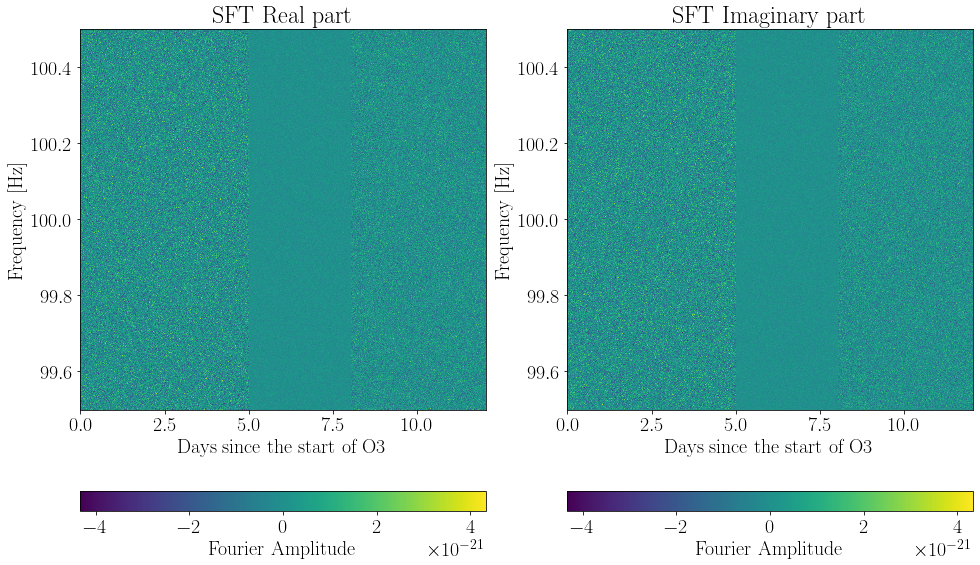

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

for ax in axs:
    ax.set(xlabel="Days since the start of O3", ylabel="Frequency [Hz]")

time_in_days = (timestamps["H1"] - timestamps["H1"][0]) / 86400
vmin = np.minimum(fourier_data["H1"].real.min(), fourier_data["H1"].imag.min())
vmax = np.maximum(fourier_data["H1"].real.max(), fourier_data["H1"].imag.max())
    
axs[0].set_title("SFT Real part")
c = axs[0].pcolormesh(time_in_days, frequency, fourier_data["H1"].real,
                      norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")


axs[1].set_title("SFT Imaginary part")
axs[1].pcolormesh(time_in_days, frequency, fourier_data["H1"].imag,
                  norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

# Gaps<a name="gaps"></a>

TO DO: MASK DATA SO ITS PROPERLY PLOTTED

In [30]:
timestamps = {"H1": 1238166018 + 1800 * np.array([0, 10, 15.5, 30])}

# Setup Writer
writer_kwargs ={"label": "single_detector_gaps",
                "outdir": "Pyfstat_example_data",
                "timestamps": timestamps,
                "F0": 100.,               # Central frequency band [Hz]
                "Band": 1.,               # Frequency band-width [Hz]
                "sqrtSX": 1e-23,          # Single-sided Amplitude Spectral Density of the noise
                "Tsft": 1800,             # Fourier transform time duration
                "SFTWindowType": "tukey", # Window function to compute short Fourier transforms
                "SFTWindowBeta": 0.01,    # Parameter associated to the window function
               }
writer = pyfstat.Writer(**writer_kwargs)

# Create SFTs
writer.make_data()
frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

15:17 INFO    : Creating Writer object...
15:17 INFO    : Generating SFTs with fmin=99.5, Band=1.0
15:17 INFO    : Got h0=0, not writing an injection .cff file.
15:17 INFO    : Checking if we can re-use existing SFT data file(s)...
15:17 INFO    : ...OK: file(s) found matching 'Pyfstat_example_data/H-4_H1_1800SFT_single_detector_gaps-1238166018-55800.sft'.
15:17 INFO    : ...checking new commandline against existing SFT header(s)...
15:17 INFO    : ......commandlines unmatched for first SFT in old file 'Pyfstat_example_data/H-4_H1_1800SFT_single_detector_gaps-1238166018-55800.sft'. Will create new SFT file(s).
15:17 INFO    : Now executing: lalapps_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="Pyfstat_example_data" --outLabel="single_detector_gaps" --IFOs="H1" --sqrtSX="1e-23" --SFTWindowType="tukey" --SFTWindowBeta=0.01 --timestampsFiles=Pyfstat_example_data/single_detector_gaps_timestamps_H1.csv --fmin=99.5 --Band=1 --Tsft=1800 --ephemEarth="/home/rodrigo/gravity/venv/pyfstat/shar

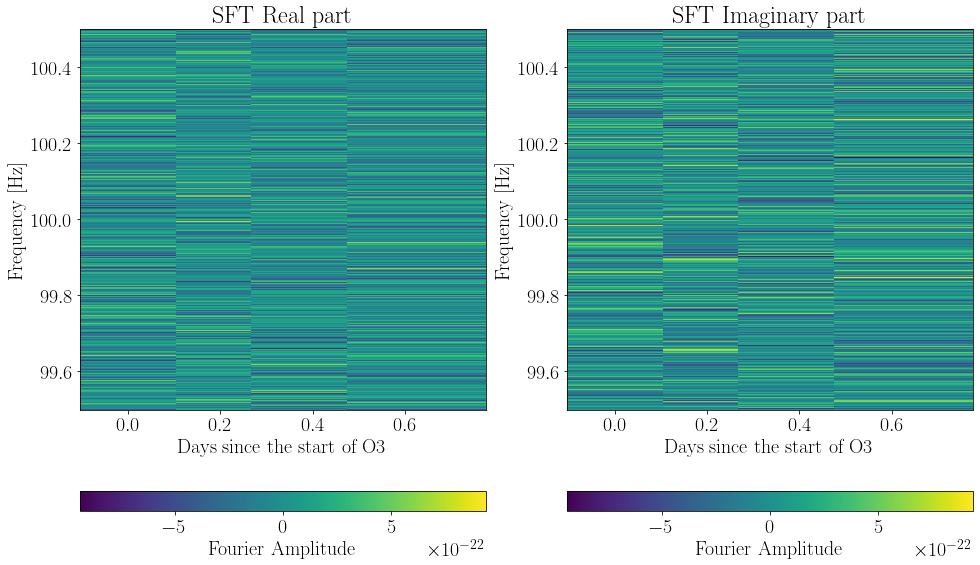

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

for ax in axs:
    ax.set(xlabel="Days since the start of O3", ylabel="Frequency [Hz]")

time_in_days = (timestamps["H1"] - timestamps["H1"][0]) / 86400
    
axs[0].set_title("SFT Real part")
c = axs[0].pcolormesh(time_in_days, frequency, fourier_data["H1"].real,
                      norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")


axs[1].set_title("SFT Imaginary part")
axs[1].pcolormesh(time_in_days, frequency, fourier_data["H1"].imag,
                  norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

## Narrow instrumental artifacts<a name="lines"></a>

In [27]:
# Setup Writer
writer_kwargs ={"label": "single_detector_spectral_line",
                "outdir": "Pyfstat_example_data",
                "tstart": 1238166018,     # Starting time of the observating [GPS time]
                "duration": 5 * 86400,    # Duration [seconds]
                "detectors": "H1",        # Detector to simulate, in this case LIGO Hanford
                "F0": 100.,               # Frequency of spectral line [Hz]
                "h0": 1e-24,              # Amplitude of the spectral line
                "phi": 3.1,               # Initial phase of the spectral line
                "Band": 1.,               # Frequency band-width [Hz]
                "sqrtSX": 1e-23,          # Single-sided Amplitude Spectral Density of the noise
                "Tsft": 1800,             # Fourier transform time duration
                "SFTWindowType": "tukey",
                "SFTWindowBeta": 0.01,
               }

writer = pyfstat.LineWriter(**writer_kwargs)
writer.make_data()

frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

15:03 INFO    : Creating LineWriter object...
15:03 WARNING : Injection of line artifacts only uses the following parameters:
['F0', 'phi', 'h0'].
Any other parameter will be purged from this class now
15:03 INFO    : Purging input parameters that are not meaningful for LineWriter: ['refTime', 'transientWindowType', 'f2dot', 'psi', 'f1dot']
15:03 INFO    : Generating SFTs with fmin=99.5, Band=1.0
15:03 INFO    : Checking if we can re-use injection config file...
15:03 INFO    : ...OK: config file Pyfstat_example_data/single_detector_spectral_line.cff already exists.
15:03 INFO    : ...OK: file contents match, no update of Pyfstat_example_data/single_detector_spectral_line.cff required.
15:03 INFO    : Checking if we can re-use existing SFT data file(s)...
15:03 INFO    : ...OK: file(s) found matching 'Pyfstat_example_data/H-240_H1_1800SFT_single_detector_spectral_line-1238166018-432000.sft'.
15:03 INFO    : ...OK: The config file 'Pyfstat_example_data/single_detector_spectral_line.cff'

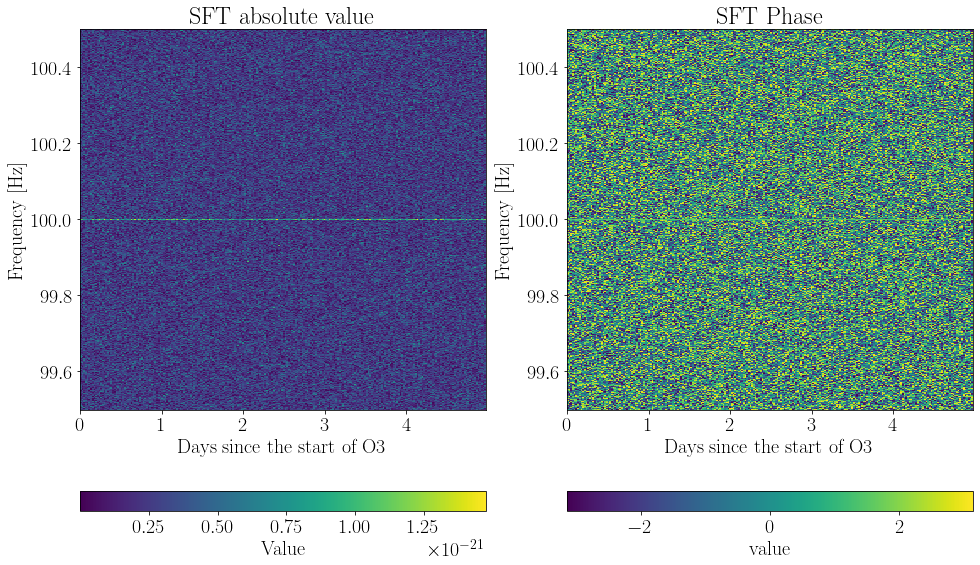

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

for ax in axs:
    ax.set(xlabel="Days since the start of O3", ylabel="Frequency [Hz]")

time_in_days = (timestamps["H1"] - timestamps["H1"][0]) / 86400
     
axs[0].set_title("SFT absolute value")
c = axs[0].pcolorfast(time_in_days, frequency, np.absolute(fourier_data["H1"]))
fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Value")

axs[1].set_title("SFT Phase")
c = axs[1].pcolorfast(time_in_days, frequency, np.angle(fourier_data["H1"]),
                      norm=colors.CenteredNorm())
fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Value")

## Multiple detectors

In [33]:
# Setup Writer
writer_kwargs ={"label": "single_detector_gaussian_noise",
                "outdir": "Pyfstat_example_data",
                "tstart": 1238166018,     # Starting time of the observating [GPS time]
                "duration": 5 * 86400,    # Duration [seconds]
                "detectors": "H1,L1",        # Detector to simulate, in this case LIGO Hanford
                "F0": 100.,               # Central frequency band [Hz]
                "Band": 1.,               # Frequency band-width [Hz]
                "sqrtSX": 1e-23,          # Single-sided Amplitude Spectral Density of the noise
                "Tsft": 1800,             # Fourier transform time duration
                "SFTWindowType": "tukey", # Window function to compute short Fourier transforms
                "SFTWindowBeta": 0.01,    # Parameter associated to the window function
               }
writer = pyfstat.Writer(**writer_kwargs)

# Create SFTs
writer.make_data()

frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

15:19 INFO    : Creating Writer object...
15:19 INFO    : Generating SFTs with fmin=99.5, Band=1.0
15:19 INFO    : Got h0=0, not writing an injection .cff file.
15:19 INFO    : Checking if we can re-use existing SFT data file(s)...
15:19 INFO    : ...OK: file(s) found matching 'Pyfstat_example_data/L-240_L1_1800SFT_single_detector_gaussian_noise-1238166018-432000.sft'.
15:19 INFO    : ...checking new commandline against existing SFT header(s)...
15:19 INFO    : ......OK: Commandline matched with old SFT header(s).
15:19 INFO    : ...all data consistency checks passed: Looks like existing SFT data matches current options, will re-use it!
15:19 INFO    : Loading 480 SFTs from H1, L1...
15:19 INFO    : done!
15:19 INFO    : 240 retrieved from H1.
15:19 INFO    : 240 retrieved from L1.


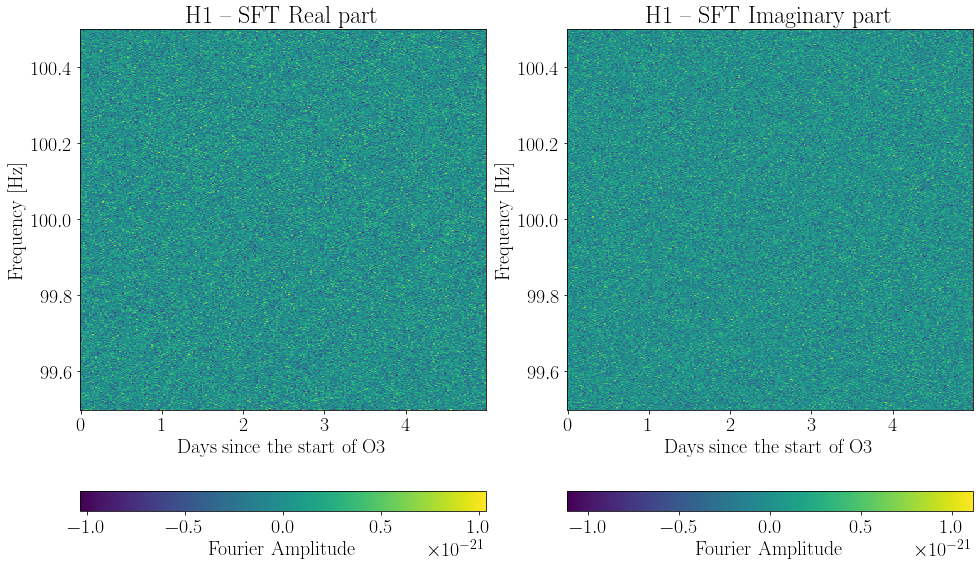

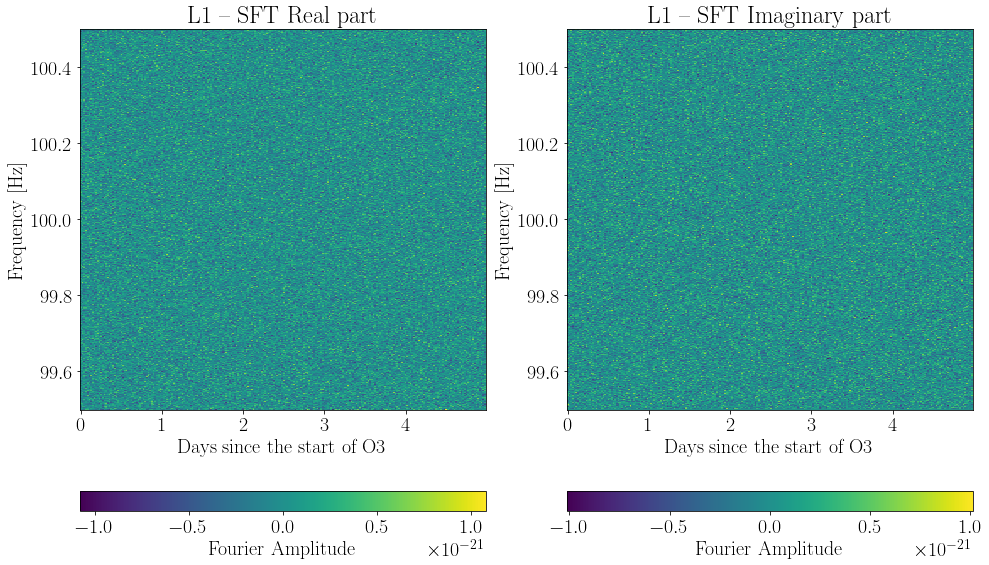

In [36]:
for ifo in timestamps.keys():

    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="Days since the start of O3", ylabel="Frequency [Hz]")

    time_in_days = (timestamps[ifo] - timestamps[ifo][0]) / 86400


    axs[0].set_title(f"{ifo} -- SFT Real part")
    c = axs[0].pcolormesh(time_in_days, frequency, fourier_data[ifo].real,
                          norm=colors.CenteredNorm())
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

    axs[1].set_title(f"{ifo} -- SFT Imaginary part")
    c = axs[1].pcolormesh(time_in_days, frequency, fourier_data[ifo].imag,
                          norm=colors.CenteredNorm())

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")